In [ ]:
#dependencies
!pip install scvi-tools
!pip install scikit-misc
!pip install scanpy
!pip install leidenalg

In [55]:
import scvi
import scanpy as sc

from matplotlib.pyplot import rc_context
sc.set_figure_params(dpi=100)

In [2]:
ls lung*

lung1.h5  lung2.h5  lung3.h5


In [3]:
#where your adata comes from doesn't matter, you just need adata
#these are 10x output h5 files
data1 = sc.read_10x_h5('lung1.h5')
data2 = sc.read_10x_h5('lung2.h5')
data3 = sc.read_10x_h5('lung3.h5')

data1.var_names_make_unique()
data2.var_names_make_unique()
data3.var_names_make_unique()

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
data1

AnnData object with n_obs × n_vars = 12324 × 32286
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
#skip if you have only 1 sample
adata = data1.concatenate(data2, data3, batch_key = "Sample")

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [7]:
adata

AnnData object with n_obs × n_vars = 34521 × 32286
    obs: 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'

In [8]:
#pp
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 3)
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)
adata = adata[adata.obs.pct_counts_mt < 15]

In [13]:
adata.obs.head()

,Sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCCAAGCAACAAT-1-0,0,1709,1709,4205.0,9.0,0.214031
AAACCCAAGGAGGGTG-1-0,0,1108,1108,1912.0,51.0,2.667364
AAACCCAAGGTCCCTG-1-0,0,3801,3801,13180.0,300.0,2.276176
AAACCCACAACGCATT-1-0,0,2302,2302,5953.0,106.0,1.780615
AAACCCACACCAGCGT-1-0,0,4228,4228,18872.0,331.0,1.753921


In [11]:
adata.layers['counts'] = adata.X.copy() #IMPORTANT, this is used by scVI. This will not change

In [12]:
#normalize data that can be used for other scanpy functions, etc. 
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [14]:
#you want fewer than the number of cells and no more than 10k
#more takes longer to train model
#
sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset = True, layer = 'counts',
                           flavor = "seurat_v3", batch_key="Sample") #no batch_key if one sample

In [15]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts'])

#get rid of categorical_covariate_keys if only one sample

In [16]:
model = scvi.model.SCVI(adata)

In [17]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

In [18]:
model.train() #may take a while without GPU

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE

Epoch 1/243:   0%|                                      | 0/243 [00:00<?, ?it/s]

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:61: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/jrlab2019/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 243/243: 100%|███████| 243/243 [06:25<00:00,  1.59s/it, loss=903, v_num=1]


In [19]:
latent = model.get_latent_representation() #this is what you will use to cluster now instead of PCs like normal

In [21]:
latent.shape

(32943, 10)

In [22]:
adata.obsm['X_scVI'] = latent

In [23]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [24]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

In [25]:
adata.obs.head()

,Sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,_scvi_batch,_scvi_labels,leiden
AAACCCAAGCAACAAT-1-0,0,1709,1709,4205.0,9.0,0.214031,0,0,2
AAACCCAAGGAGGGTG-1-0,0,1108,1108,1912.0,51.0,2.667364,0,0,0
AAACCCAAGGTCCCTG-1-0,0,3801,3801,13180.0,300.0,2.276176,0,0,0
AAACCCACAACGCATT-1-0,0,2302,2302,5953.0,106.0,1.780615,0,0,1
AAACCCACACCAGCGT-1-0,0,4228,4228,18872.0,331.0,1.753921,0,0,13


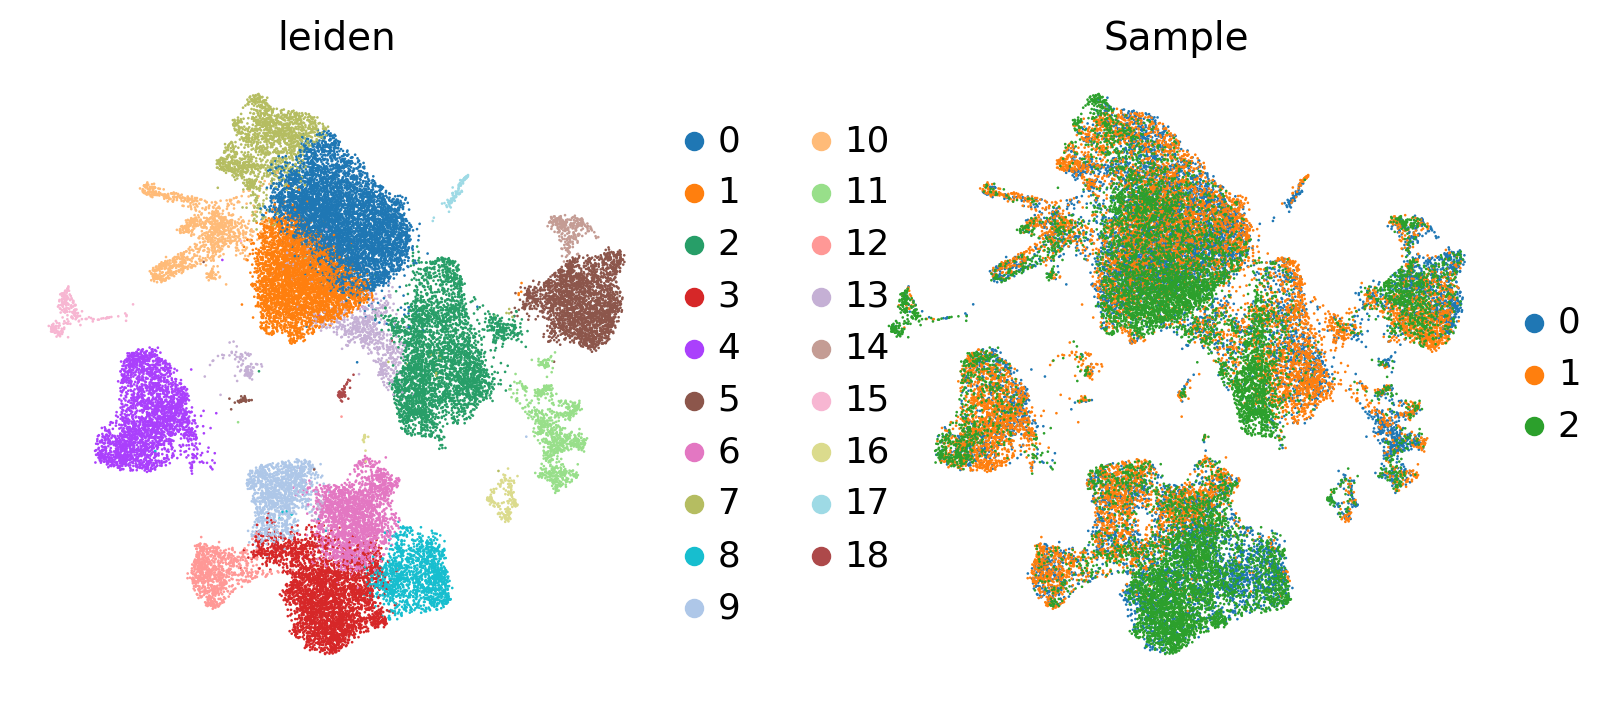

In [43]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)

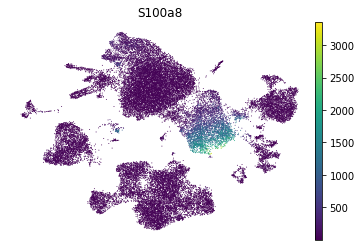

In [30]:
sc.pl.umap(adata, color = ['S100a8'], frameon = False, layer = 'scvi_normalized')

In [46]:
#find markers of each cluster
df = model.differential_expression(groupby = 'leiden')

df

DE...: 100%|████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
C1qc,0.9772,0.0228,3.757930,0.002984,0.001748,0.0,0.25,2.633745,3.144195,2.526475,...,11.433871,7.795315,0.590048,0.257527,34.664433,23.006231,True,0 vs Rest,0,Rest
Gm15056,0.9772,0.0228,3.757930,0.000534,0.000086,0.0,0.25,3.553070,3.685093,2.443203,...,1.698519,0.155776,0.119318,0.022591,5.767198,0.613744,True,0 vs Rest,0,Rest
Ccl2,0.9740,0.0260,3.623314,0.008205,0.001332,0.0,0.25,3.380475,3.623020,1.800406,...,36.384651,4.007836,0.844869,0.341072,108.813034,13.368085,True,0 vs Rest,0,Rest
Ccl7,0.9740,0.0260,3.623314,0.003822,0.000628,0.0,0.25,3.296299,3.473639,1.889216,...,18.322927,2.293390,0.594180,0.214483,56.736111,7.423192,True,0 vs Rest,0,Rest
Folr2,0.9736,0.0264,3.607636,0.000062,0.000022,0.0,0.25,3.129871,3.499137,2.670854,...,0.146694,0.059997,0.060950,0.019864,0.478626,0.164146,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ckap4,0.7134,0.2866,0.911955,0.000195,0.000196,0.0,0.25,0.077210,0.095750,0.722777,...,0.212766,0.374721,0.191489,0.185524,2.129076,1.532930,False,18 vs Rest,18,Rest
Aurka,0.7096,0.2904,0.893442,0.000048,0.000059,0.0,0.25,0.239198,0.224638,1.077266,...,0.021277,0.111015,0.021277,0.054627,0.337724,0.379647,False,18 vs Rest,18,Rest
Chpt1,0.6882,0.3118,0.791718,0.000286,0.000287,0.0,0.25,0.088417,0.033662,0.721629,...,0.085106,0.469078,0.085106,0.259150,0.840954,2.090049,False,18 vs Rest,18,Rest
Xbp1,0.6874,0.3126,0.787992,0.000943,0.000936,0.0,0.25,0.097917,0.127707,0.584830,...,0.787234,2.101068,0.446809,0.559430,7.794172,8.932205,False,18 vs Rest,18,Rest


In [53]:
markers = {}
for c in adata.obs.leiden.cat.categories:
    cell_df = df.loc[df.group1 == c]
    markers[c] = cell_df.index.tolist()[:2]

In [54]:
markers

{'0': ['C1qc', 'Gm15056'],
 '1': ['C1qa', 'C1qc'],
 '2': ['Cstdc4', 'S100a8'],
 '3': ['Gzmf', 'Pcp4l1'],
 '4': ['Cd79a', 'H2-Ob'],
 '5': ['Ldb2', 'Sox17'],
 '6': ['Tnfrsf4', 'Adam12'],
 '7': ['Clec9a', 'Gpr141'],
 '8': ['Pclaf', 'Asf1b'],
 '9': ['1700062C10Rik', 'Lef1'],
 '10': ['Slc27a3', 'Nudt17'],
 '11': ['Prelp', 'Ism1'],
 '12': ['Foxa3', 'Tcrg-C4'],
 '13': ['Klk1', 'Dntt'],
 '14': ['Xpnpep2', 'Rprml'],
 '15': ['Jchain', 'Igkv5-39'],
 '16': ['1110017D15Rik', 'Aqp5'],
 '17': ['Marco', 'Gm13571'],
 '18': ['Defb40', 'Dnase2b']}

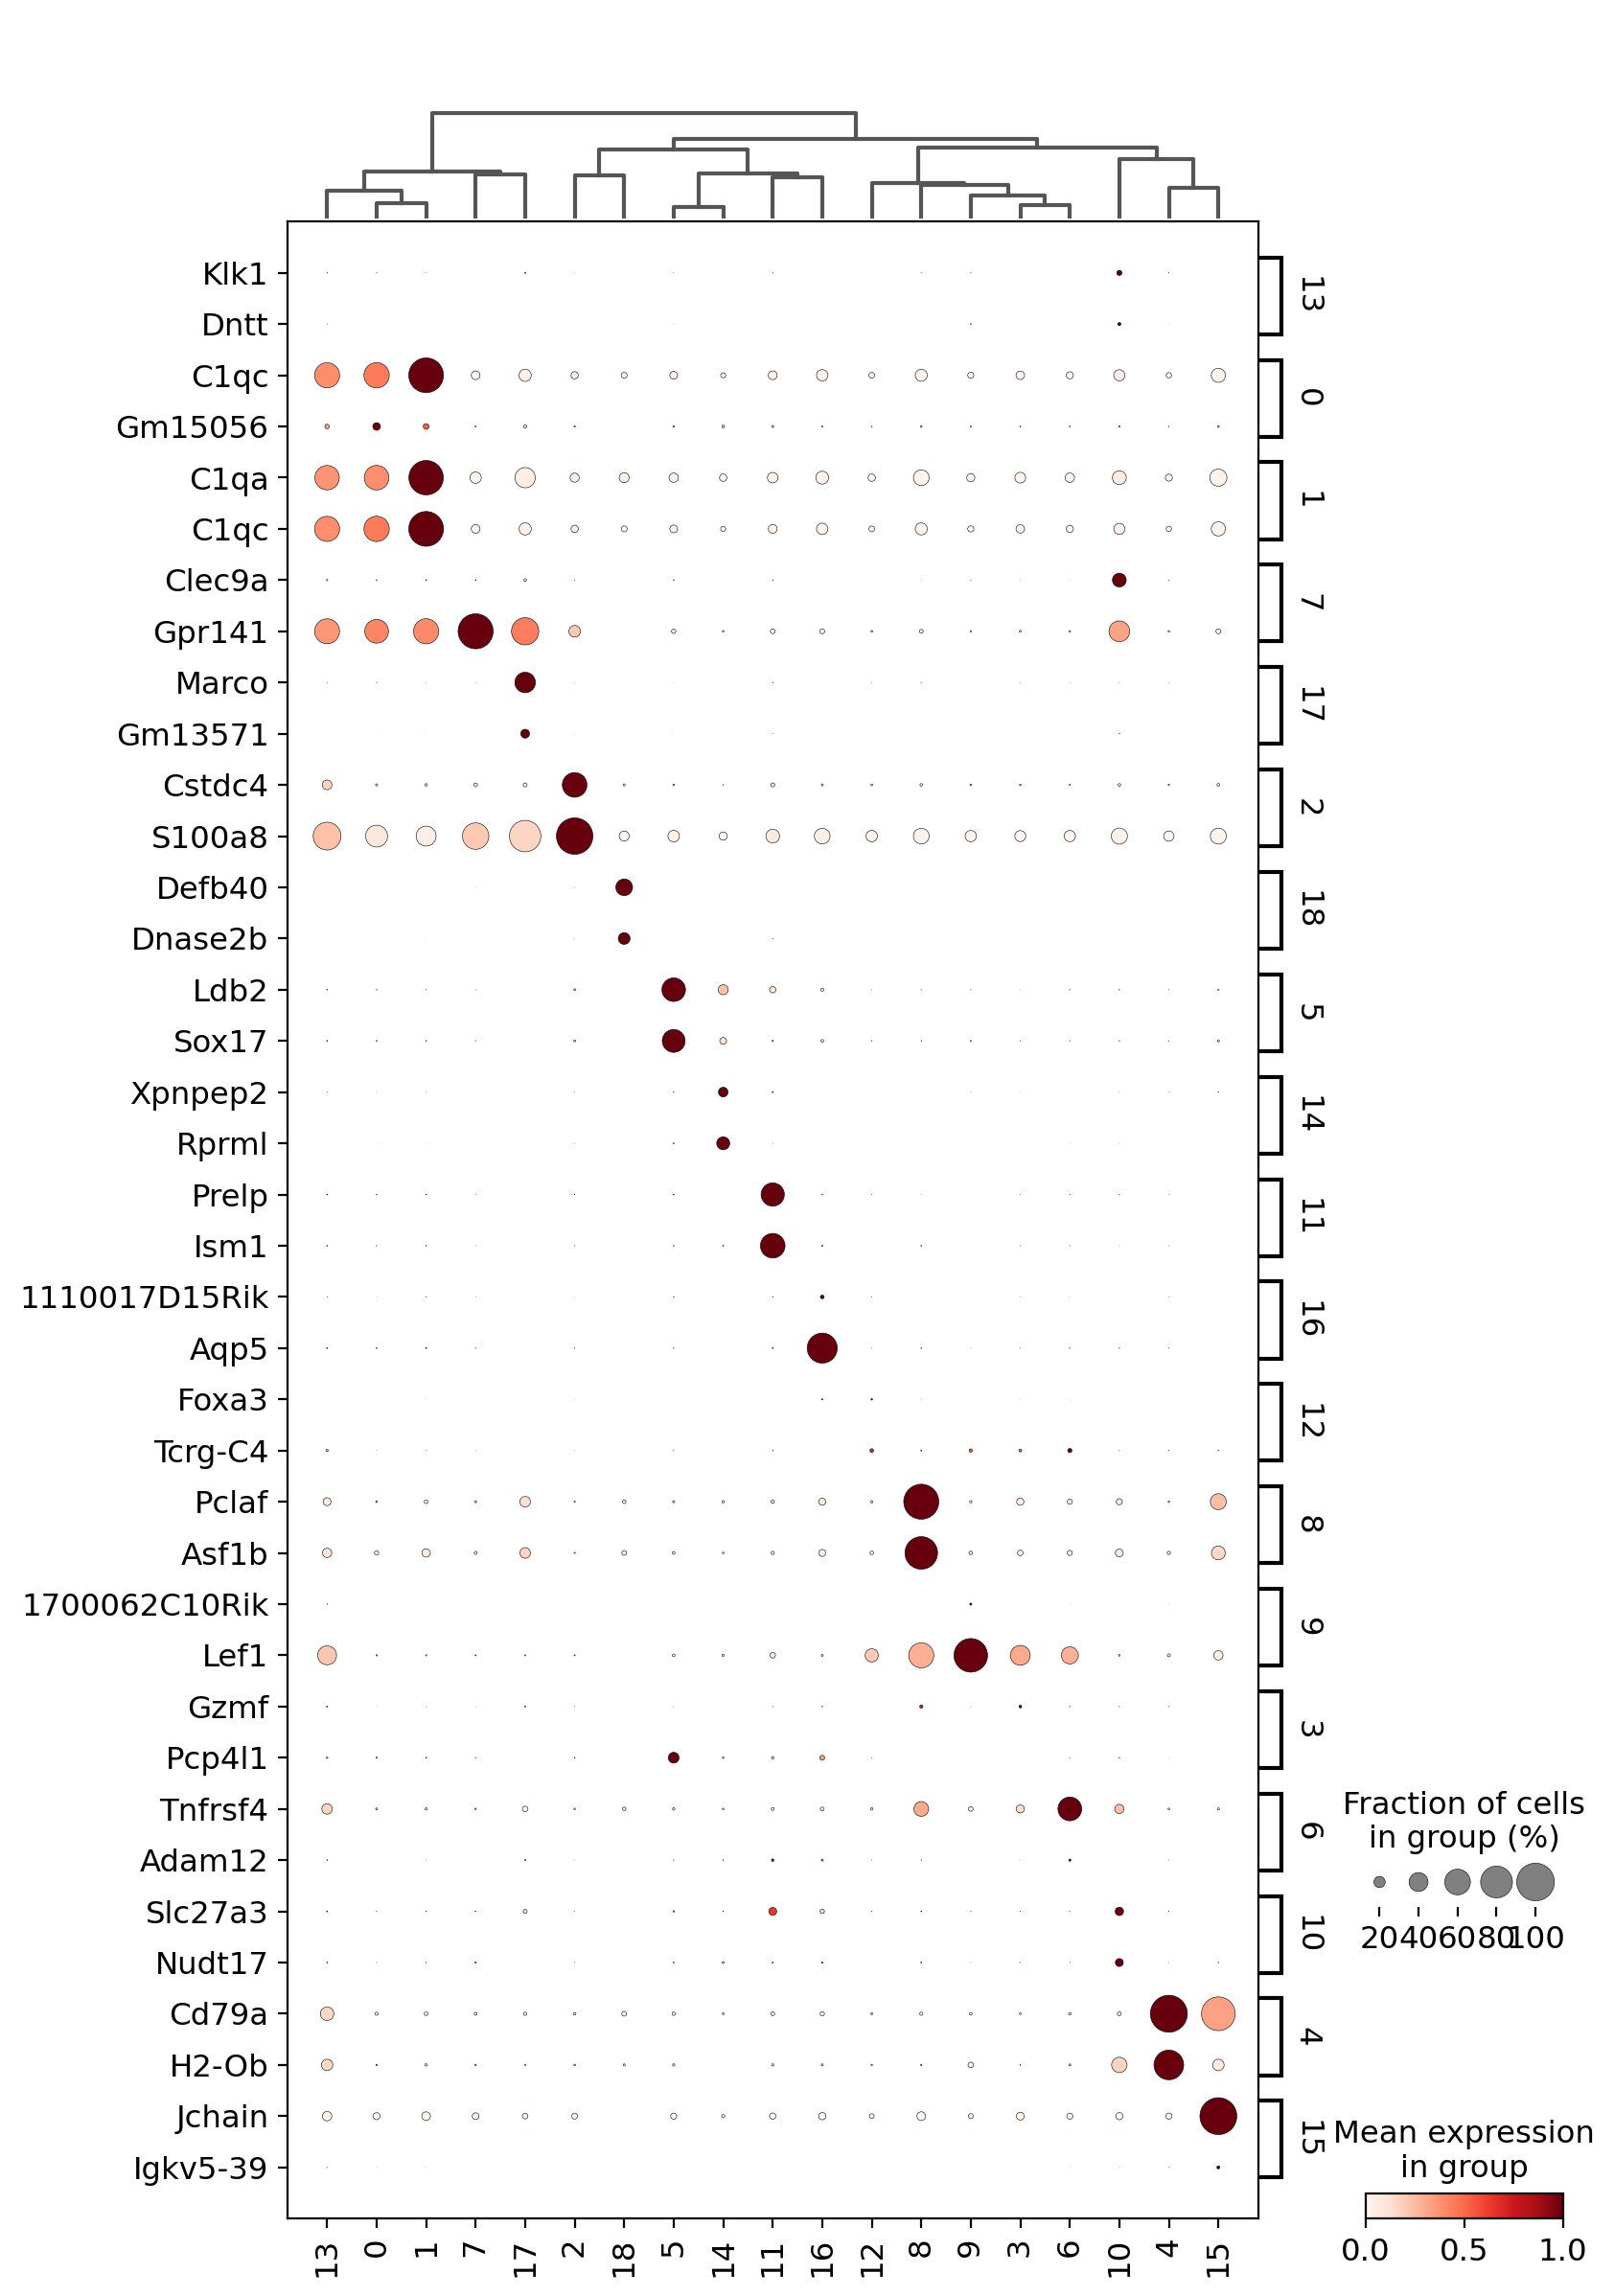

In [56]:
sc.pl.dotplot(adata, markers, groupby = 'leiden', swap_axes = True,
             use_raw = True, standard_scale = 'var', dendrogram = True)

In [ ]:
#sample 1 vs sample 2
sc.pl.dotplot(adata, markers, groupby = 'leiden', swap_axes = True,
             use_raw = True, standard_scale = 'var', dendrogram = True)

In [36]:
model.differential_expression(groupby = "Sample", group1 = '0', group2 = '2')

DE...: 100%|██████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Klk1,0.9666,0.0334,3.365229,0.000842,0.004172,0.0,0.25,-1.670512,-1.593068,5.307407,...,0.046425,0.005631,0.003310,0.000536,0.350877,0.026134,True,0 vs 2,0,2
Dntt,0.9650,0.0350,3.316780,0.000090,0.000557,0.0,0.25,-2.320992,-2.262817,4.901375,...,0.003310,0.002592,0.001307,0.000894,0.028964,0.022526,True,0 vs 2,0,2
Cyp2a4,0.9622,0.0378,3.236913,0.000014,0.000040,0.0,0.25,-1.153745,-1.223685,4.413178,...,0.000087,0.004201,0.000087,0.000715,0.000650,0.012768,True,0 vs 2,0,2
Il12b,0.9610,0.0390,3.204413,0.000017,0.000012,0.0,0.25,0.972875,1.019949,4.428594,...,0.023953,0.015731,0.002787,0.002235,0.078966,0.070185,True,0 vs 2,0,2
Camp,0.9598,0.0402,3.172858,0.000109,0.000271,0.0,0.25,-1.873352,-1.890687,4.432951,...,0.065151,0.067662,0.002265,0.002503,0.142399,0.137713,True,0 vs 2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dstn,0.7446,0.2554,1.070016,0.000668,0.000718,0.0,0.25,-0.093166,-0.115072,0.823295,...,1.047210,1.445611,0.449264,0.534769,4.994703,6.306919,False,0 vs 2,0,2
Edem2,0.7402,0.2598,1.047008,0.000245,0.000269,0.0,0.25,-0.140067,-0.139739,0.778869,...,0.387165,0.568018,0.262521,0.327404,1.964342,2.370173,False,0 vs 2,0,2
Xbp1,0.7360,0.2640,1.025281,0.000954,0.000893,0.0,0.25,0.096849,0.109066,0.756226,...,1.655116,2.664183,0.563017,0.558009,8.509134,8.869423,False,0 vs 2,0,2
Chpt1,0.7332,0.2668,1.010919,0.000283,0.000280,0.0,0.25,0.036383,-0.050115,0.933520,...,0.435593,0.480417,0.244578,0.277261,2.117499,2.026326,False,0 vs 2,0,2


In [41]:
#any set of cells vs any set of cells
model.differential_expression(idx1 = [(adata.obs.Sample == '0') & (adata.obs.leiden == '1')],
                             idx2 = [(adata.obs.Sample == '1') & (adata.obs.leiden == '1')])

DE...: 100%|██████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
Dntt,0.9558,0.0442,3.073824,0.000005,0.000011,0.0,0.25,-1.975827,-2.097909,3.578142,-12.614717,12.128912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
Siglech,0.9490,0.0510,2.923583,0.000067,0.000168,0.0,0.25,-1.610399,-1.742848,2.877398,-13.137639,9.658446,0.012100,0.011996,0.003559,0.004362,0.061519,0.039886,True
Klk1,0.9482,0.0518,2.907175,0.000041,0.000063,0.0,0.25,-1.506905,-1.593320,3.324085,-12.039818,12.149983,0.002135,0.001091,0.002135,0.001091,0.011118,0.005466,True
Gstp1,0.9368,0.0632,2.696165,0.000135,0.000325,0.0,0.25,-1.290705,-1.327751,0.755778,-3.812675,1.615230,0.270462,0.929120,0.214235,0.503817,0.930885,2.938962,False
Wfdc1,0.9358,0.0642,2.679398,0.000002,0.000007,0.0,0.25,-1.608222,-1.608308,1.159319,-5.897398,2.723089,0.000000,0.002181,0.000000,0.002181,0.000000,0.007380,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gk,0.5302,0.4698,0.120947,0.000474,0.000446,0.0,0.25,0.083898,0.071263,0.407722,-1.554166,1.542177,1.208541,0.806981,0.409964,0.350055,4.389343,2.450281,False
Glipr1,0.5284,0.4716,0.113722,0.000467,0.000537,0.0,0.25,-0.200650,-0.201359,0.337141,-1.417706,1.141479,0.827755,1.568162,0.390747,0.523446,2.996731,4.747145,False
Aoah,0.5072,0.4928,0.028802,0.000545,0.000574,0.0,0.25,-0.076202,-0.085243,0.385846,-1.682178,1.875279,1.112455,1.219198,0.515302,0.577972,4.277577,3.838839,False
Arl6ip1,0.4886,0.5114,-0.045608,0.001793,0.001808,0.0,0.25,-0.001066,-0.005321,0.423585,-2.049761,2.228710,3.538799,4.551824,0.850534,0.909487,14.307377,13.944982,False


In [40]:
[(adata.obs.Sample == '0') & (adata.obs.leiden == '1')]

[AAACCCAAGCAACAAT-1-0    False
 AAACCCAAGGAGGGTG-1-0    False
 AAACCCAAGGTCCCTG-1-0    False
 AAACCCACAACGCATT-1-0     True
 AAACCCACACCAGCGT-1-0    False
                         ...  
 TTTGTTGTCCGCGAGT-1-2    False
 TTTGTTGTCGAGAATA-1-2    False
 TTTGTTGTCTATTTCG-1-2    False
 TTTGTTGTCTCGACCT-1-2    False
 TTTGTTGTCTCGAGTA-1-2    False
 Length: 32943, dtype: bool]